In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

In [2]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

In [3]:
char2int_smb = { 
    "X": 0,  # smb unpassable
    "S": 1,  # smb breakable
    "-": 2,
    "?": 3,  # smb question
    "Q": 4,  # smb question
    "E": 5,
    "<": 6,
    ">": 7,
    "[": 8,
    "]": 9,
    "o": 10,
    "P": 11,  # for smb path (from Anurag's email)
}
int2char = {v:k for k, v in char2int_smb.items()}
char2name = {
    'X': 'unpassable',
    'S': 'breakable',
    '-': 'background',
    '?': 'SMB question',
    'Q': 'SMB question',
    'E': 'SMB enemy',
    '<': 'Top-left pipe element',
    '>': 'Top-right pipe element',
    '[': 'Bottom-left pipe element',
    ']': 'Bottom-right pipe element',
    'o': 'Coins',
    'P': 'Player path'
}

## Density

In [5]:
RESULTS_DIR = '/home/yangz2/projects/gmvae_and_gmmvae/results'
GAME = 'smba'
MODEL = 'gmvae'
num_components=10

In [16]:
json_fname = f'{RESULTS_DIR}/{GAME}_{MODEL}_generations/{GAME}_{MODEL}_{num_components}.json'
num_components = int(json_fname.split('_')[-1].split('.')[0])
num_gens_per_comp = 500

In [17]:
chunks_int = open_json_as_nparray(json_fname)
begin, end = 0, num_gens_per_comp
chunks_by_comp = []
for i in range(num_components):
    chunks_by_comp.append(chunks_int[begin:end])
    begin, end = begin + num_gens_per_comp, end + num_gens_per_comp

In [18]:
def get_densities(chunks):
    unique_indices = np.unique(chunks)
    densities = {i:[] for i in unique_indices}
    for idx, chunk in enumerate(chunks):
        for i in unique_indices:
            chunk_mod = chunk == i
            densities[i].append(np.count_nonzero(chunk_mod))
    return [np.mean(v) for k, v in densities.items()]

In [19]:
densities_by_comp = [get_densities(chunks) for chunks in chunks_by_comp]
len(densities_by_comp)

10

In [20]:
df = pd.DataFrame(densities_by_comp)
df = df.fillna(0)
df /= df.max()
df.columns = [int2char[i] for i in np.unique(chunks_int)]
df = df.iloc[:,:-1]
df.head()

,X,S,-,?,Q,E,<,>,[,],o
0,0.333051,0.065109,0.995503,0.385246,0.080092,0.116766,0.051392,0.049793,0.069432,0.063361,0.107467
1,0.441923,0.068460,0.958960,0.229508,0.068650,0.685629,0.807281,0.786307,0.812444,0.785124,0.050565
2,0.399631,0.042470,0.997017,0.549180,1.000000,0.386228,0.111349,0.103734,0.001803,0.089991,1.000000
3,1.000000,0.080594,0.879079,0.245902,0.082380,0.446108,0.321199,0.296680,0.299369,0.293848,0.010685
4,0.520174,0.185366,0.926103,0.311475,0.102975,0.901198,1.000000,1.000000,1.000000,1.000000,0.017021


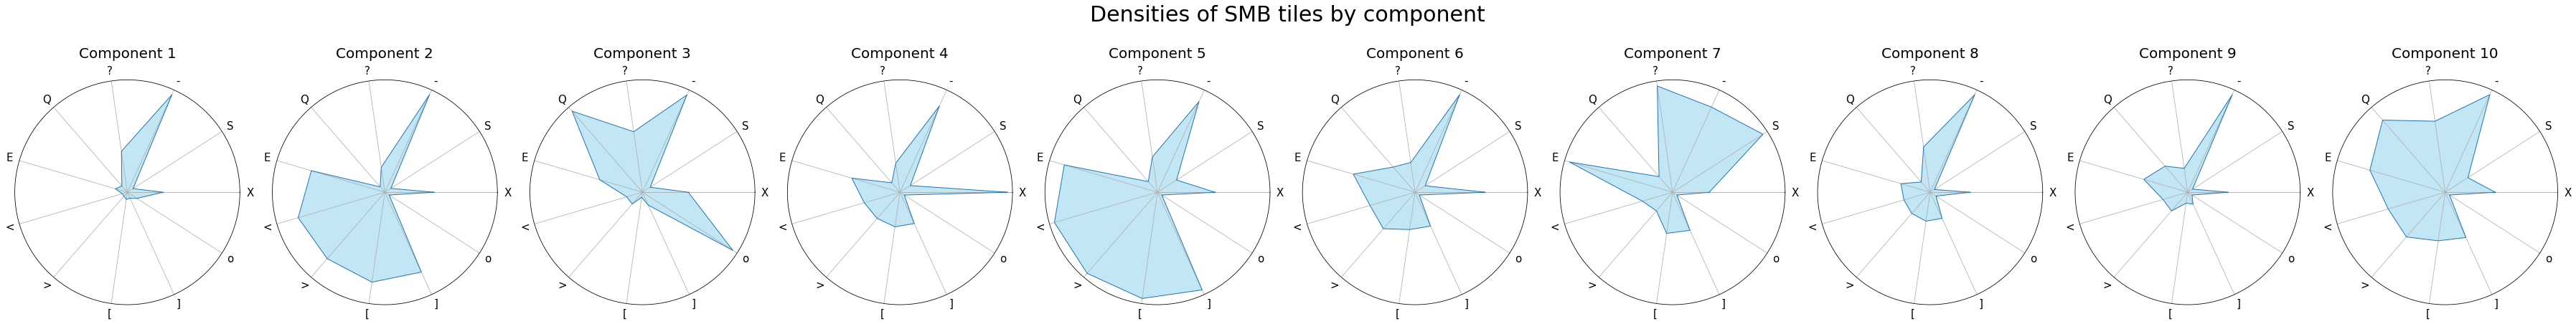

In [21]:
categories = list(df)

fig, axs = plt.subplots(nrows=1, ncols=num_components, figsize=(num_components * 5, 5),
                           subplot_kw=dict(polar=True))
axs = axs.flatten()

for i in range(num_components):
    
    ax = axs[i]
    
    values = df.iloc[i].tolist()
    values += values[:1] # repeat the first value to close the circular graph
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=15)
    ax.set_yticks([])
    ax.set_rlabel_position(30)

    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'skyblue', alpha=0.5)
    
    ax.set_title(f'Component {i+1}', y=1.08, fontsize=20)

plt.suptitle('Densities of SMB tiles by component', y=1.20, fontsize=30)
plt.tight_layout()
plt.show()

## Plotting generations from each component

In [22]:
import sys
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

In [23]:
def get_images(chunks_int):
    images = []
    for chunk in chunks_int:
        images.append(vglc_with_path_encodings.array_to_image([chunk], game='smba')[0])
    return images

/home/yangz2/anaconda3/envs/deep_learning/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


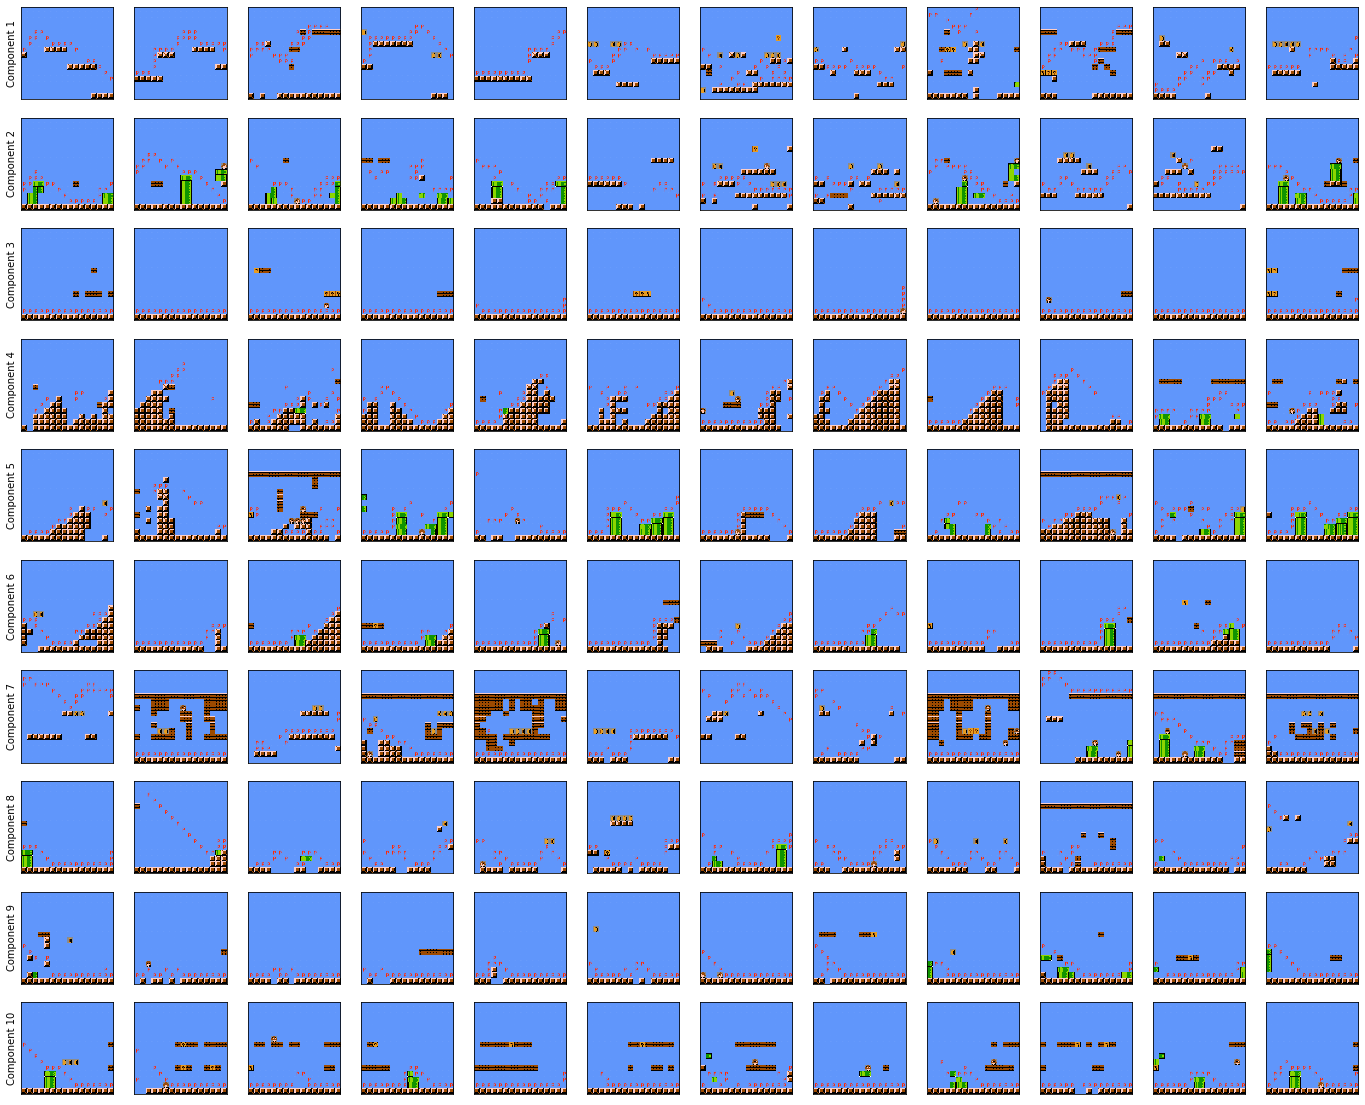

In [24]:
num_cols = 12
fig, axs = plt.subplots(num_components, num_cols, figsize=(2 * num_cols, 2 * num_components))
for comp_idx, chunks in enumerate(chunks_by_comp):
    imgs = get_images(chunks[:num_cols])
    for img_idx, img in enumerate(imgs):
        if img_idx == 1:
            ax.set_ylabel(f'Component {comp_idx + 1}')
        ax = axs[comp_idx][img_idx]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
# plt.savefig(f'SMB generations per component (GM-VAE {num_components}).png', dpi=300)